In [5]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# read the pickle file
with open('../tracker_stubs/ball_detections.pkl', 'rb') as f:
    ball_positions = pickle.load(f)


In [7]:
ball_positions = [x.get(1, []) for x in ball_positions]

# convert the list into a pandas dataframe
df_ball_positions = pd.DataFrame(ball_positions, columns=['x1', 'y1', 'x2', 'y2'])

# interpolate the missing values
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill()

In [9]:
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2']) / 2
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean()

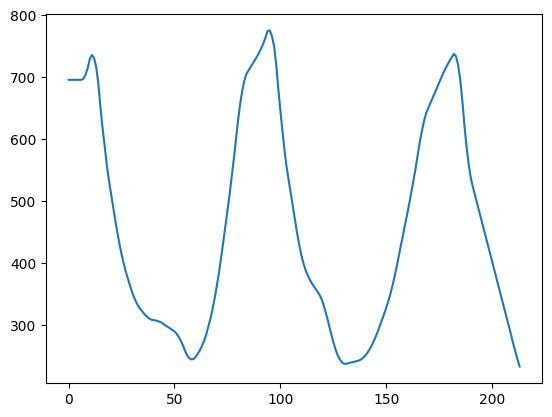

In [10]:
# plot the mid_y_rolling_mean
plt.plot(df_ball_positions['mid_y_rolling_mean'])

In [11]:
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()

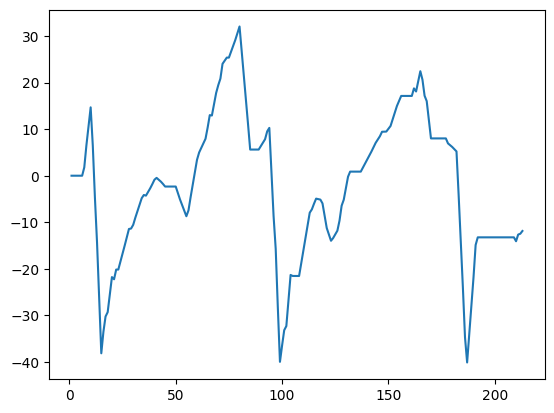

In [12]:
# plot delta_y
plt.plot(df_ball_positions['delta_y'])

In [13]:
df_ball_positions['ball_hit'] = 0

In [14]:
minimum_change_frames_for_hit = 25
for i in range(1, len(df_ball_positions) - int(minimum_change_frames_for_hit * 1.2)):
    negative_position_change = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[i + 1] < 0

    positive_position_change = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[i + 1] > 0 

    if (negative_position_change or positive_position_change):
        change_count = 0
        for change_frame in range(i + 1, i + int(minimum_change_frames_for_hit * 1.2) + 1):
            negative_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[change_frame] < 0
            positive_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[change_frame] > 0

            if (negative_position_change and negative_position_change_following_frame):
                change_count += 1
            elif (positive_position_change and positive_position_change_following_frame):
                change_count += 1
        
        if (change_count > minimum_change_frames_for_hit - 1):
            df_ball_positions['ball_hit'].iloc[i] = 1

frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit'] == 1].index.tolist()

/var/folders/p3/4wck83gx26vgx0yzpkx3y24w0000gn/T/ipykernel_48151/2435698504.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_ball_positions['ball_hit'].iloc[i] = 1
/var/folders/p3/4wck83gx26vgx0yzpkx3y24w0000gn/T/ipykernel_48151/24356

In [16]:
df_ball_positions[df_ball_positions['ball_hit'] == 1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
11,777.505920,717.588745,796.757629,738.734619,728.161682,735.775745,6.500073,1
58,925.428918,241.399649,938.752112,254.693777,248.046713,243.884221,-1.921125,1
95,624.208252,748.890930,641.804047,767.237396,758.064163,775.360049,0.811270,1
131,717.253918,231.325616,731.095996,245.660321,238.492969,236.740778,-0.225269,1
182,1296.682251,740.032837,1313.209717,758.088867,749.060852,737.525043,5.219165,1
